In [1]:
import cv2
import numpy as np
#import preprocess
from preprocess import preprocess
from matplotlib import pyplot as plt
import math

%matplotlib inline


In [2]:
#from pdftabextract import imgproc


In [3]:
from matplotlib import pyplot as plt
imgfile = 'Image from iOS.jpg'
#imgfile = 'sample.jpg'
img = cv2.imread(imgfile)
clean_img = preprocess(imgfile, remove_lines=True)

-87.129638671875
(3508, 2479)
(3508, 2479)


Angle before correction-87.1286392211914


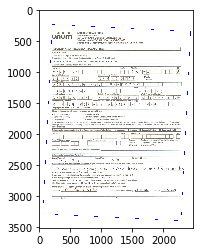

In [4]:
imgfile = 'Image from iOS.jpg'
#imgfile = 'sample.jpg'
image = cv2.imread(imgfile)

# Non-local Means (NLM)
denoised = image
#denoised = cv2.fastNlMeansDenoising(image, None,h=10,templateWindowSize=7,searchWindowSize=21) 

# Transform source image to gray if it is not already
if len(denoised.shape) != 2:
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
else:
    gray = denoised

gray = cv2.bitwise_not(gray)



# Thresholding
# threshold the image, setting all foreground pixels to
# 255 and all background pixels to 0
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] # Otsu

#coords = np.column_stack(np.where(thresh > 0))
coords = cv2.findNonZero(thresh)
rect = cv2.minAreaRect(coords)
angle = rect[-1]
print('Angle before correction' + str(angle))

box = cv2.boxPoints(rect)
box = np.int0(box)
img = cv2.drawContours(image,[box],0,(0,0,255),2)
plt.imshow(img, cmap='gray')
plt.imsave('rot_bbox', img, cmap='gray')

In [5]:
box


array([[2287, 3391],
       [  62, 3279],
       [ 215,  232],
       [2440,  344]])

Angle after correction -2.8713607788085938


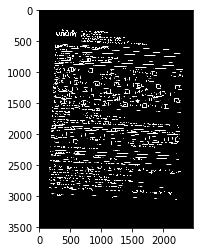

In [6]:
# the `cv2.minAreaRect` function returns values in the
# range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we
# need to add 90 degrees to the angle
if angle < -45:
    angle = -(90 + angle)

# otherwise, just take the inverse of the angle to make
# it positive
else:
    angle = -angle

print('Angle after correction ' + str(angle))

# rotate the image to deskew it
(h, w) = thresh.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(thresh, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
plt.imshow(rotated, cmap='gray')

In [7]:
def compute_skew(file_name):
    
    #load in grayscale:
    src = cv2.imread(file_name,0)
    height, width = src.shape[0:2]
    
    #invert the colors of our image:
    cv2.bitwise_not(src, src)
    
    #Hough transform:
    minLineLength = width/2.0
    maxLineGap = 20
    lines = cv2.HoughLinesP(src,1,np.pi/180,100,minLineLength,maxLineGap)
    
    #calculate the angle between each line and the horizontal line:
    angle = 0.0
    nb_lines = len(lines)
    
    
    for line in lines:
        angle += math.atan2(line[0][3]*1.0 - line[0][1]*1.0,line[0][2]*1.0 - line[0][0]*1.0);
    
    angle /= nb_lines*1.0
    
    return angle* 180.0 / np.pi



In [8]:
def deskew(file_name,angle):
    
    #load in grayscale:
    img = cv2.imread(file_name,0)
    
    #invert the colors of our image:
    cv2.bitwise_not(img, img)
    
    #compute the minimum bounding box:
    non_zero_pixels = cv2.findNonZero(img)
    center, wh, theta = cv2.minAreaRect(non_zero_pixels)
    
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1)
    rows, cols = img.shape
    rotated = cv2.warpAffine(img, rot_mat, (cols, rows), flags=cv2.INTER_CUBIC)


    #Border removing:
    sizex = np.int0(wh[0])
    sizey = np.int0(wh[1])
    print(theta)
    if theta > -45 :
        temp = sizex
        sizex= sizey
        sizey= temp
    return cv2.getRectSubPix(rotated, (sizey,sizex), center)


-0.7937733998657228
Angle after correction 0.7937733998657228


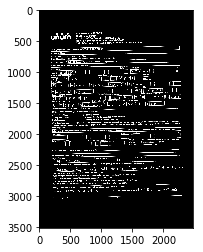

In [9]:
angle = compute_skew(imgfile)
print(angle)
# the `cv2.minAreaRect` function returns values in the
# range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we
# need to add 90 degrees to the angle
if angle < -45:
    angle = -(90 + angle)

# otherwise, just take the inverse of the angle to make
# it positive
else:
    angle = -angle

print('Angle after correction ' + str(angle))

# rotate the image to deskew it
(h, w) = thresh.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(thresh, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
plt.imshow(rotated, cmap='gray')

-0.18617571890354156


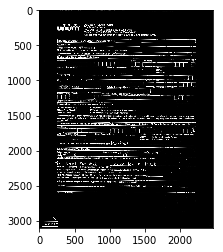

In [10]:
#imgfile = 'Image from iOS.jpg'
imgfile = 'sample.jpg'
angle = compute_skew(imgfile)
rotated = deskew(imgfile, angle)

plt.imshow(rotated, cmap='gray')

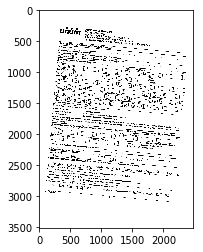

In [11]:
plt.imshow(clean_img, cmap='gray')

In [12]:
plt.imsave('clean_img_no_lines', clean_img, cmap='gray')